# 驗證模型的各項指標

參考文件
1. http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
2. https://blog.csdn.net/cherdw/article/details/55813071
3. http://alexkong.net/2013/06/introduction-to-auc-and-roc/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [4]:
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import svm, datasets

##  範例
取得資料集

In [9]:
import pandas as pd

In [30]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target

將Y轉乘one-hot vector

In [31]:
Y_2 = label_binarize(Y, classes=[0, 1, 2])
n_classes = y.shape[1]
print("n_classes:%d"%n_classes)

n_classes:3


無聊增加800個沒意義的變數，讓問題變更難一點

In [34]:
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
print("n_samples:%d, n_features:%d"%X.shape)
X_2 = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
pd.DataFrame(X_2).head()

n_samples:150, n_features:4


,0,1,2,3,4,5,6,7,8,9,...,794,795,796,797,798,799,800,801,802,803
0,5.1,3.5,1.4,0.2,1.764052,0.400157,0.978738,2.240893,1.867558,-0.977278,...,-0.757871,-0.050084,-0.897401,1.312470,-0.858972,-0.898942,0.074586,-1.077099,-0.424663,-0.829965
1,4.9,3.0,1.4,0.2,1.411172,0.785804,-0.057470,-0.391217,0.940918,0.405204,...,-1.116950,-0.035297,0.241204,1.127784,0.881131,1.032989,-0.923912,1.412152,-1.380431,-0.535915
2,4.7,3.2,1.3,0.2,0.430771,-0.149892,-1.006037,-0.821550,-1.548254,0.531975,...,-0.110591,-0.432432,1.077037,-0.224827,-0.576242,0.574609,-0.489828,0.658802,-0.596917,-0.222959
3,4.6,3.1,1.5,0.2,0.152177,-0.374126,-0.013451,0.815472,0.410602,0.480970,...,0.847408,-0.198720,1.575307,0.849115,-1.228895,0.888394,-0.516487,-0.083326,0.131054,-0.879096
4,5.0,3.6,1.4,0.2,-1.333342,0.367784,-1.388233,-2.575203,-0.836106,0.331092,...,-1.468367,0.576479,0.065306,-0.773513,0.394948,-0.503890,1.779559,-0.030572,1.577088,-0.812802


分割資料為 train 與 test 資料集

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X_2, Y_2, test_size=.5,random_state=0)

In [38]:
X_test.shape

(75, 804)

建立模型

In [40]:
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,random_state=random_state))
model = classifier.fit(X_train, Y_train)

取得score

In [43]:
Y_score = model.decision_function(X_test)

計算作圖資料

In [44]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# 其中 np.ravel() 就是做 flatten但不做變數clone，直接回傳reference
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [56]:
Y_test[:,]

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0,

In [53]:
roc_auc

{0: 0.9118165784832452,
 1: 0.6029629629629629,
 2: 0.7859477124183007,
 'micro': 0.7274666666666667}

In [50]:
roc_auc["micro"]

0.7274666666666667

作圖

- FPR = 不會發生，但預測發生的比率 = NP / N
- TPR = 會發生，預測發生的比率 = TP / P
- 最理想狀況 (FPR,TPR) = (0,1), 但是最糟糕就是 (FPR,TPR) = (1,0), 然後全部預測不會發生就是(0,0) 預測全部發生就會是(1,1)
- 所以最理想的預測就是整個曲線越往左上越好
- 基本上在AUC上，y = x 幾乎就是隨機作圖的成果，任一個模型應該都會是比這個好


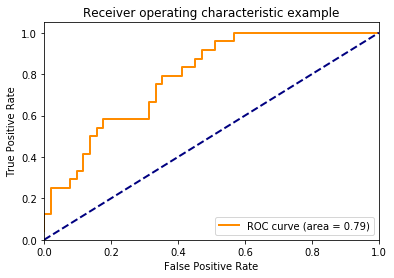

In [51]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()